# Analysing a sample ECG dataset
I have used The Long-Term AF Database and WFDB python package from __[PhysioNet](https://physionet.org)__ for my analysis.
## Reading and preprocessing the dataset
First import all needed packages.

In [176]:
import wfdb
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn.over_sampling as ov
import sklearn as sk

To download the dataset, use dl_databse function from wfdb package.

In [5]:
wfdb.dl_database('ltafdb', os.getcwd() + '/data')

Finished downloading files


Now read the data for a subject and find the sample numbers related to atrial fibrillation.

In [2]:
# For reading more about wfdb modules one can use help e.g. help(wfdb.rdsamp)
ann = wfdb.rdann('data/01', 'atr')
ann.symbol = pd.Series(ann.symbol)
ann.sample = pd.Series(ann.sample)
# Boolean is used to find the indices of the R-peaks that are annotated with "A"
boolean = pd.Series(ann.symbol=='A')
print(ann.sample[boolean].head(10))

5      6305
9      6676
22     7619
24     7814
26     7996
29     8200
32     8432
38     9047
54    10271
64    11040
dtype: int64


Do the same for normal heart beats.

In [3]:
boolean = pd.Series(ann.symbol=='N')
print(ann.sample[boolean].head(10))

1     5969
3     6119
4     6232
6     6412
7     6495
8     6602
10    6781
11    6848
12    6939
14    7093
dtype: int64


Based on the above values, the region between 6200 and 7200 seems to have normal heart beat, while the region between 7300 and 8300 has atrial fibrillation. Now, read the samples related to these two regions using rdsamp and plot these regions to see the difference between atrial fibrillation and normal beats.

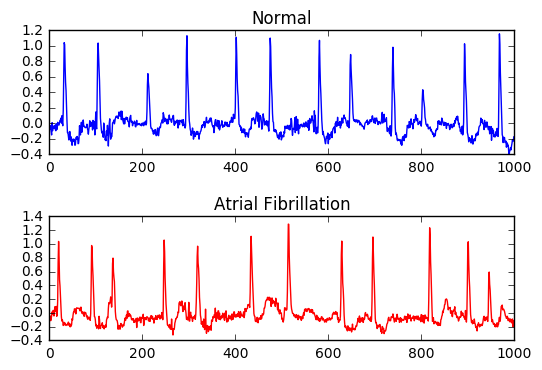

In [4]:
samp1 = wfdb.rdsamp('data/01',channels=[0], sampfrom=6200,sampto=7200)
samp2 = wfdb.rdsamp('data/01',channels=[0], sampfrom=7300,sampto=8300)
plt.subplot(2, 1, 1)
plt.title('Normal')
plt.plot(samp1[0])
plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0.5)
plt.title('Atrial Fibrillation')
plt.plot(samp2[0], color='red')
plt.show()

Define a class that is used to get every record, segment it, extract features, and label the segments.

In [131]:
class Subjects:
    """Subjects and their corresponding feature sets"""
    
    def __init__(self, sample, symbol):
        self.sample = pd.Series(list(sample)[1:])
        self.symbol = pd.Series(list(symbol)[1:])
        self.filtr()
        self.calculaterr()
        
# Changes the indices of a series to range(0,length_of_the_series)
    def reindex(self, series):
        series = series.reset_index()
        series.drop('index', axis=1, inplace=True)
        return(series[0])
    
# Interpolate heart beats with NaNs and divide heart beats into two classes: Normal and Abnormal
    def filtr(self):
        self.symbol.interpolate(inplace=True)
        self.sample.interpolate(inplace=True)
        self.sample = self.reindex(self.sample)
        self.symbol = self.reindex(self.symbol)
        self.symbol = self.symbol.replace('V', 'A')
        
# Claculate R-R intervals
    def calculaterr(self):
        self.rr = pd.Series(list(self.sample - self.sample.shift(1))[1:])

# Delete the end of the record if it is not divisible by segment length
    def cutend(self, n):
        self.sample = self.sample[0:(len(self.sample)//n)*n]
        self.symbol = self.symbol[0:(len(self.symbol)//n)*n]
        self.rr = self.rr[0:(len(self.sample)//n)*n]

# Calculate the sum of squares of distances between every two consecutive R-R intervals
    def dist(self, data):
        data = (data - data.shift(1))**2
        data = data.sum()
        return(data)
    
# Extract different features from the dataset (mean, standard deviation, RMSSD, and Normalised RMSSD)
    def extractfeatures(self, n):
        groups = self.rr.groupby(np.arange(len(self.rr))//n)
        self.means = groups.mean()
        self.sds = groups.std()        
        self.rmssd = np.sqrt(groups.apply(self.dist)/(n-1))
        self.nrmssd = self.rmssd/self.means

# Compare the number of Abnormal beats to a given threshold (n*r).
# If all beats in a segment are unclassified, it returns abnormal
    def compare(self, data, n, r):
        numQ = sum(data == 'Q')
        n -= numQ
        numA = sum(data == 'A')
        if numA >= n * r:
            return 'A'
        else:
            return 'N'

# Set the label of each segment by comparing the ratio of abnormal beats to a given threshold (r)
    def label(self, n, r):
        groups = self.symbol.groupby(np.arange(len(self.symbol))//n)
        self.labels = groups.apply(self.compare, n, r)

# Segment records, label the segments, and extract features from them.
    def segment(self, n, r):
        if (len(self.rr)%n):
            self.cutend(n)
        self.extractfeatures(n)
        self.label(n, r)

Read all ".atr" files and make them objects of the above class in order to segment them, extract features and label the segments.

In [133]:
list_of_files = os.listdir('data')
list_of_files = ['data/' + i[:-4] for i in list_of_files if i.endswith('.atr')]
data = pd.DataFrame({'mean':[], 'sd':[], 'rmssd':[], 'nrmssd':[], 'label':[]},
                    columns=['mean', 'sd', 'rmssd', 'nrmssd', 'label'])
for item in list_of_files:
    ann = wfdb.rdann(item, 'atr')
    subj = Subjects(ann.sample, ann.symbol)
    subj.segment(20, 1/3)
    toappend = pd.DataFrame({'mean':subj.means, 'sd':subj.sds, 'rmssd':subj.rmssd, 'nrmssd':subj.nrmssd,
                             'label':subj.labels}, columns=['mean', 'sd', 'rmssd', 'nrmssd', 'label'])
    data = pd.concat([data, toappend])
data = data.reset_index()
data.drop('index',axis=1,inplace=True)
print(data.head(10))

    mean         sd      rmssd    nrmssd label
0  60.70  11.397599  16.916202  0.278685     N
1  70.15  14.683593  22.942720  0.327052     N
2  65.55  14.383744  20.958606  0.319735     N
3  61.60  11.226848  14.950796  0.242708     N
4  58.85  10.825287  16.309506  0.277137     N
5  55.75  12.619429  17.047920  0.305792     N
6  61.05  11.776314  15.471536  0.253424     N
7  63.30  12.465109  15.271232  0.241252     N
8  67.50  19.930141  24.716285  0.366167     N
9  67.60  11.375875  18.338915  0.271286     N


## Over-sampling
Our dataset is imbalanced because most of the time the heart beats are normal. Therefore, normal data points outnumber atrial fibrillation cases. So, we need to generate some synthetic atrial fibrillation data points. I use imblearn package for this.

In [171]:
sm = ov.SMOTE()
data = data.loc[~data.isnull().any(axis=1),:]
sdata, slabel = sm.fit_resample(data.loc[:, data.columns != 'label'], data.loc[:,'label'])
sdata = pd.DataFrame(sdata, columns=['mean', 'sd', 'rmssd', 'nrmssd'])
slabel = pd.Series(slabel)
sdata['label'] = slabel

Let's see how the data looks before and after over-sampling. I only compare two features; standard deviaion and Normalised RMSSD.

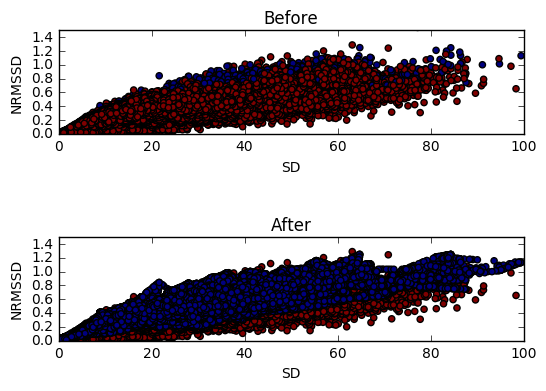

In [173]:
colors = data['label'] == 'N'
scolors = sdata['label'] == 'N'
plt.subplot(2, 1, 1)
plt.title('Before')
plt.scatter(data['sd'], data['nrmssd'], c=colors)
plt.xlim((0,100))
plt.xlabel('SD')
plt.ylim((0,1.5))
plt.ylabel('NRMSSD')
plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=1)
plt.title('After')
plt.scatter(sdata['sd'], sdata['nrmssd'], c=scolors)
plt.xlim((0,100))
plt.xlabel('SD')
plt.ylim((0,1.5))
plt.ylabel('NRMSSD')
plt.show()

## Classification
Now, we separate the training and test sets and run classification algorithms.

In [178]:
train, test = sk.model_selection.train_test_split(sdata, test_size=0.2)

              mean         sd       rmssd    nrmssd label
821338   87.421077  25.617208   39.292551  0.449462     A
61516   119.450000  44.285527   59.943394  0.501828     N
660968   69.373830  29.299645   43.588466  0.628321     A
550493  107.302530  28.407597   47.844387  0.445903     A
304543  113.650000  17.406215   26.461491  0.232833     N
789464  100.144119  27.501033   40.171925  0.401141     A
857176   62.190105  27.475244   47.071038  0.756912     A
672045   99.050742  53.182437   88.586044  0.894390     A
425328  110.600000  15.076646   23.615338  0.213520     N
780928   82.106449  32.947002   41.407775  0.504311     A
48611    98.250000   3.552242    2.271100  0.023116     N
184977   78.350000  14.815621   20.399948  0.260369     N
512040   82.406759  34.103113   50.960833  0.618411     A
762200  103.172463  32.232799   61.841857  0.599417     A
852722  133.018417  83.511233  103.481643  0.779336     A
64278    85.850000  10.668572   15.386255  0.179223     N
842634  114.02

In [ ]:
https://wfdb.readthedocs.io/en/latest/io.html#module-wfdb.io
https://physionet.org/physiobank/database/ltafdb/tables.shtml
https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed